I quote heavily from the official TensorFlow website, namely their Programmers' Guide for [Importing Data](https://www.tensorflow.org/programmers_guide/datasets), and copy what's there verbatim (since it's the official API guide), largely for convenience (I don't have a wifi connection all the time, even like for people in rural USA, and so how can you access the official programmers' guide offline?), while adding my notes on top of it.  So feel free to copy, edit, paste as you'd like too.  

In [1]:
import tensorflow
import tensorflow as tf
print("You have version %s" % tf.__version__)

You have version 1.4.0


In [2]:
# For fast (data) visualization 
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# as a sanity check, let's use Pandas and numpy 
# as the previous method of data pipelining  
import pandas
import pandas as pd  
import numpy 
import numpy as np 

In [4]:
# Using Python (native, built-in) libraries os, sys 
# is a great way to check if we have the files we need in our 
# local file directories
import os, sys
print(os.getcwd()) # get the current, local file directory
print(os.listdir(os.getcwd() )) # list the current directory

/home/mobicfd/ReacCFD/advanced-tensorflow/LinearRegression
['LinearRegression.ipynb', '.ipynb_checkpoints', 'graphs']


### Sample `.txt` data  
#### cf. Coursera, *Introduction to Machine Learning* by Prof. Ng  
Join the free class, download the homework and they're in the files `machine-learning-ex1.zip`, `machine-learning-ex2.zip` and in the folders `ex1/ex1data1.txt`, `ex2/ex1data2/txt`, respectively, and save them locally here.  

`ex1data1.txt` is a simple case, where the data is clean, there's no header, and 

input data $X \in \text{Mat}_{\mathbb{R}}(m,d)$, with $m$ being the number of examples given (97 in this case) and there are only $d=1$ features of our input data, and 

the output data, on the "right-most column", is $y\in \text{Mat}_{\mathbb{R}}(m,K)$, with $K$ being the dimension of the output ($K=1$ in this case).  

Note that we want to find a linear relationship from $X_i \in \mathbb{R}$ to $y_i \in \mathbb{R}$, i.e.  

$$ 
    X_i \mapsto y_i  
$$ 

$\forall \, i \in 0,1,\dots m-1$.  

As a note on notation, $\mathbb{R}$ stands for the set of all real numbers, and for computers they correspond to float or double types.  For GPUs, we work with 32-bit floating-point numbers (this is because of the hardware architecture of GPUs).  

In [5]:
sample_datasets_subdir_str = "sample_datasets/"
sample_datasets_basedir_str = "../"

In [6]:
for filename in os.listdir(sample_datasets_basedir_str + sample_datasets_subdir_str):
    if filename.endswith(".txt"): 
        print filename

ex1data2.txt
ex1data1.txt


In [7]:
sample_datasets_fileloc_str = sample_datasets_basedir_str + sample_datasets_subdir_str

# `.txt` $\to$  `tf.data.Dataset`  

`TextLineDataset`, a class inheriting from the `Datasets` base class *reads lines from text files*.  By default, it'll read *every* line of each file.   


In [9]:
ex1data1_Dataset = tf.data.TextLineDataset( sample_datasets_fileloc_str + "/ex1data1.txt")
print(type(ex1data1_Dataset))

<class 'tensorflow.python.data.ops.readers.TextLineDataset'>


## Dataset structure (check)  

Let's take a look at the dataset structure when we do `tf.data.TextLineDataset` (i.e. `.txt` $\to$ `tf.data`)

In [10]:
print(ex1data1_Dataset.output_types)  
print(ex1data1_Dataset.output_shapes)

<dtype: 'string'>
()


The datasets comprises of elements each of the same structure (or type).  

Now write a Python function to parse this string; for [`tf.decode_csv`](https://www.tensorflow.org/api_docs/python/tf/decode_csv), the API (i.e. the input parameters to use),  
```  
decode_csv(records,record_defaults,field_delim=',',use_quote_delim=True,name=None,na_value='') 
```  
`records` is a `Tensor` of type `string` (which we have in thise case) and each string is a record/row in the `csv` and all the "records" is assumed to have the same format (for our `.txt` file).  

In [11]:
def decode_func_txt(line):
    record_defaults =[[0.0],[0.0]]
    line = tf.decode_csv(line, record_defaults=record_defaults, field_delim=',')
    return line[:-1], line[-1] # X_i, y_i, only the last value in a line 
                            # is the output value, the prior values are input values

[`.batch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), `.batch(batch_size)`, combines consecutive elements of a dataset into batches, and `batch_size` is a `tf.int64` scalar `tf.Tensor` (i.e. a positive integer $\in \mathbb{Z}^+$, representing the number of consecutive elements of this dataset to combine in a single batch.   

Let $m_i = $ size of a single batch $ \in \mathbb{Z}^+$

In [12]:
# m_i = size of a single batch  
m_i = 64

In [13]:
ex1data1_Dataset = ex1data1_Dataset.batch(m_i)
print(type(ex1data1_Dataset))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


[`.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), `.map(map_func, num_parallel_calls=None)` maps the `map_func` (e.g. a Python function) across the dataset, where `map_func` is a "function mapping a nested structure of tensors (having shapes and types defined by `self.output_shapes` and `self.output_types`) to another nested structure of tensors, and  

`num_parallel_calls` is a `tf.int32` scalar `tf.Tensor` (i.e. it's a positive integer $\in \mathbb{Z}^+$) representing the number of elements to process in parallel (on a GPU(s)!).  

In [14]:
ex1data1_Dataset = ex1data1_Dataset.map(decode_func_txt, num_parallel_calls=m_i)

In [15]:
print(ex1data1_Dataset)

<ParallelMapDataset shapes: ((1, ?), (?,)), types: (tf.float32, tf.float32)>


[`.shuffle`](https://www.tensorflow.org/programmers_guide/datasets#randomly_shuffling_input_data) randomly shuffles the input dataset using a similar algorithm to `tf.RandomShuffleQueue`.  It maintains a fixed-size buffer, which is a positive integer $\in \mathbb{Z}^+$ (that you must input), and out of that buffer, chooses the next element uniformly at random from the buffer.  

In [67]:
#Uncomment out when we want to do the shuffling; 
# later, we want to check if our data is the same as if we had used Pandas+NumPy
#shuffle_buffer_size = 10000
#ex1data1_Dataset.shuffle(shuffle_buffer_size)

So to recapitulate, once you've gotten  
$$   
    \verb|.txt| \xrightarrow{ tf.data.TextLineDataset } \verb|<string>|
$$    
i.e. turned a text file into a string with `tf.data.TextLineDataset`, apply these 3 transformations:  

- `.batch`
- `.map` (remember to define what function you'd want to do on each line or "record" to process your `.txt` file; I'll try to provide examples of writing this function in these jupyter notebooks)
- `.shuffle`  

There are of course other transformations you can do to get your data ready: 
- `.filter` - write a function to process each line or "record" and you can do things like filter out empty lines 
- `.repeat` - repeat indefinitely  

[`.repeat`](https://www.tensorflow.org/programmers_guide/datasets#training_workflows) is going to be important for when training your data.  The Programmers' guide describes it as "process multiple epochs of the same data," "to iterate over a dataset in multiple epochs".  I believe it means this: for example, let's say we want to do gradient descent to train our model, i.e. find the global minimum to minimize cost function(al) $J$, for our "weight" or parameter $\Theta$.  At iteration $t$, to obtain the next iteration $t+1$, 

$$   
\Theta(t+1) := \Theta(t) - \alpha \frac{ \partial J}{ \partial \Theta}(\Theta(t))  
$$  

and "epoch" is synonymous to iteration, here.  

So we'll go ahead and do `.repeat()` (repeat indefinitely).  

In [16]:
ex1data1_Dataset.repeat(1)
print(type(ex1data1_Dataset))

<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>


Apparently, then you have to make an initializer.  There seems to be 2 ways,  

- [`.make_initializable_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), which creates an `Iterator` for enumerating the elements of this, the given, dataset; *note* the returned iterator will be in an uninitialized state, and `iterator.initializer` must be run before using it. cf. [Processing multiple epochs](https://www.tensorflow.org/programmers_guide/datasets#training_workflows)  
- [`.make_one_shot_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), was recommended by the Datasets API documentation for high-level APIs, such as `tf.estimator.Estimator` because apparently, you need to use `tf.errors.OutOfRangeError` to signal that training has completed.  cf. [Processing multiple epochs](https://www.tensorflow.org/programmers_guide/datasets#training_workflows)  

In [17]:
ex1data1_iterator = ex1data1_Dataset.make_initializable_iterator()
print(type(ex1data1_iterator))

<class 'tensorflow.python.data.ops.iterator_ops.Iterator'>


We still haven't split up our data $(X,y)$ into seperate Python objects for $X$ and $y$.  `.get_next()` seems to do it.  The API guide says this:  

[`.get_next`](https://www.tensorflow.org/api_docs/python/tf/data/Iterator) - `.get_next(name=None` - returns a nested structure of `tf.Tensor`s containing the next element.  So I assume (read into it) that it'll give the next "batch" and since it's a batch of $(X,y)$ we can split up $(X,y)$ in the following manner:  

In [18]:
X_ex1data1_next, y_ex1data1_next = ex1data1_iterator.get_next()
print(type(X_ex1data1_next))
print(type(y_ex1data1_next))

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


In [19]:
# many interesting properties to look up
print(X_ex1data1_next.dtype)
print(y_ex1data1_next.dtype)
print(X_ex1data1_next.shape)
print(y_ex1data1_next.shape)
print(X_ex1data1_next.get_shape() )
print( y_ex1data1_next.get_shape() )

<dtype: 'float32'>
<dtype: 'float32'>
(1, ?)
(?,)
(1, ?)
(?,)


## Sanity check that we've loaded the data, sanity check with how we could've done the same with Pandas + NumPy 

In [20]:
with tf.Session() as sess:
    sess.run(ex1data1_iterator.initializer)
    ex1data1_loaded_batch_X = sess.run(X_ex1data1_next)

In [21]:
ex1data1_loaded_batch_X

array([[  6.11009979,   5.52769995,   8.51860046,   7.00320005,
          5.85979986,   8.38290024,   7.4763999 ,   8.5781002 ,
          6.48619986,   5.05459976,   5.71070004,  14.16399956,
          5.73400021,   8.40839958,   5.64069986,   5.37939978,
          6.36539984,   5.13009977,   6.42959976,   7.07079983,
          6.18909979,  20.27000046,   5.49009991,   6.32609987,
          5.56489992,  18.94499969,  12.82800007,  10.95699978,
         13.17599964,  22.20299911,   5.25239992,   6.58939981,
          9.24820042,   5.89179993,   8.21109962,   7.93340015,
          8.09589958,   5.60629988,  12.83600044,   6.35340023,
          5.40689993,   6.88250017,  11.70800018,   5.77370024,
          7.82469988,   7.09310007,   5.07019997,   5.80140018,
         11.69999981,   5.54160023,   7.54020023,   5.30770016,
          7.42390013,   7.60309982,   6.33279991,   6.35890007,
          6.27419996,   5.63969994,   9.31019974,   9.45359993,
          8.82540035,   5.17929983,  21.

In [22]:
print(type(ex1data1_loaded_batch_X))
print(ex1data1_loaded_batch_X.shape)

<type 'numpy.ndarray'>
(1, 64)


Indeed, this does the same as what one might have done with Pandas + NumPy:  

In [21]:
ex1data1DF = pd.read_csv(sample_datasets_fileloc_str + "/ex1data1.txt",header=None)

In [22]:
Xyex1data1 = ex1data1DF.values
Xex1data1 = Xyex1data1[:,0]
yex1data1 = Xyex1data1[:,1]
print(Xex1data1.shape)
print(yex1data1.shape)
Xex1data1 = np.vstack(Xex1data1).astype(np.float32)
yex1data1 = np.vstack(yex1data1).astype(np.float32)
print(Xex1data1.shape)
print(yex1data1.shape)

(97,)
(97,)
(97, 1)
(97, 1)


In [25]:
Xex1data1[:64].T == ex1data1_loaded_batch_X

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]], dtype=bool)

If we got all True's above, successful sanity check!

In [26]:
# start again
tf.reset_default_graph()

To recapitulate, let's wrap all the Python class member function instantiations into Python functions:  

In [8]:
# write a function to decode a line from the text file 
def decode_func_txt(line):
    record_defaults =[[0.0],[0.0]]
    line = tf.decode_csv(line, record_defaults=record_defaults, field_delim=',')
    return line[:-1], line[-1] # X_i, y_i, only the last value in a line 
                            # is the output value, the prior values are input values  

def create_1dimXydataset_fn(path,m_i,num_repeats=None,bool_shuffle=True,
                            shuffle_buffer_size=10000):
    """
    @fn create_1dimXydataset_fun
    @param path, string, a string with the filename's path
    @param m_i, a positive integer, number of examples in a batch
    @param num_repeats, a positive integer or None, number of times to repeat, 
                        None is for indefinitely
    @param bool_shuffle = True 
    @param shuffle_buffer_size, a positive integer, default is 10000
    """
    def input_fn():
        dataset = (
            tf.data.TextLineDataset(path) # create a dataset from a file 
                .map(decode_func_txt, num_parallel_calls=m_i)
                .batch(m_i)                
        )
        
        if num_repeats is None:
            dataset=dataset.repeat() # repeat indefinitely
        else:
            dataset=dataset.repeat(num_repeats)

        if bool_shuffle:
            dataset=dataset.shuffle(shuffle_buffer_size)    
            
        # create iterator
        iterator = dataset.make_initializable_iterator()  
        
        # separate the input X data from the output y data
        X_next, y_next = iterator.get_next()

        # we'll need to return the iterator as well to initialize it at tf.Session time
        return (X_next, y_next), iterator 
    return input_fn

In [28]:
# let's test out our function
ex1data1_fn = create_1dimXydataset_fn(sample_datasets_fileloc_str + "/ex1data1.txt", 
                                      m_i, 1,False)

In [29]:
(ex1data1_X_next, ex1data1_y_next), ex1data1_iterator = ex1data1_fn()

In [30]:
with tf.Session() as sess:
    sess.run(ex1data1_iterator.initializer)
    ex1data1_loaded_batch_X = sess.run(ex1data1_X_next)

In [31]:
print( type( ex1data1_loaded_batch_X ) )
print( ex1data1_loaded_batch_X.shape)

<type 'numpy.ndarray'>
(64, 1)


In [32]:
ex1data1_loaded_batch_X.T == Xex1data1[:64].T

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]], dtype=bool)

What happens if $m_i$, batch size, is greater than examples we have in our data set, $m=97$?

In [33]:
# start again
tf.reset_default_graph()

In [34]:
ex1data1_fn = create_1dimXydataset_fn(sample_datasets_fileloc_str + "/ex1data1.txt", 
                                      128, 1,False)

In [35]:
ex1data1_Xy_next, ex1data1_iterator = ex1data1_fn()

In [36]:
with tf.Session() as sess:
    sess.run(ex1data1_iterator.initializer)
    (ex1data1_loaded_batch_X, ex1data1_loaded_batch_y) = sess.run(ex1data1_Xy_next)

In [37]:
print( type( ex1data1_loaded_batch_X ) )
print( ex1data1_loaded_batch_X.shape)

<type 'numpy.ndarray'>
(97, 1)


If we obtain a shape of `(97,1)`, then the iterator knew to stop.  

In [38]:
ex1data1_loaded_batch_X.T == Xex1data1.T

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True]], dtype=bool)

# Linear Regression Model  

We can use the data we've just pipelined through `tf.data` to make a plot in `matplotlib`:

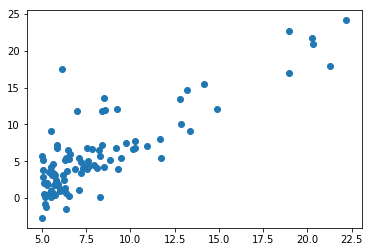

In [39]:
plt.scatter(ex1data1_loaded_batch_X,ex1data1_loaded_batch_y)

The Linear Regression Model is mathematically formally the following:  

$$
    \widehat{y} = X \Theta + b  
$$ 

where $\widehat{y}, b \in \text{Mat}_{\mathbb{R}}(m,K)$, $X \in \text{Mat}_{\mathbb{R}}(m,d)$, $\Theta \in \text{Mat}_{\mathbb{R}}(d,K)$, with bias $b$ having the particular form that  

$$
    b_{ij} = b^j \qquad \, \forall \, i =0,1,\dots m-1, \, j=0,1,\dots K-1
$$  

i.e. entries of $b$ only depends on which "column" it's in, $j$.  

Usually, one only sees this function written for linear regression:

$$  
    y = mx +b  
$$  
because we're only thinking about applying the function to 1 number, 1 example, to get the output of just this 1 input.  

But I want to point out that we want to operate on the entirety of large batches of examples; so we must consider matrices.  And usually we multiply on the left, as when we first learn matrix multiplication.   

But for GPUs, you want to multiply *from the right*.  Indeed, this has been well-formulated mathematically as *right $R$-modules*.  

The reason why, I suspect, is that in the source code of TensorFlow, for the `cuda` `platform` and `streaming` subdirectories, TensorFlow is wrapping, in C++, CUBLAS API calls and for CUBLAS, you want the first dimension of the matrix to be each successive dataset example, *not* the columns or $d$ features of your input data.  This is because you want *thread warp coalescing* when running computations on a GPU(s).  

## Define our Linear Regression model in `tf`  

In [103]:
# start again
tf.reset_default_graph()

In [77]:
ex1data1_fn = create_1dimXydataset_fn(sample_datasets_fileloc_str + "/ex1data1.txt", 
                                      64, None,True)
ex1data1_Xy_next, ex1data1_iterator = ex1data1_fn()

In [78]:
# size dimension shapes are important (and severely enforced)
d=1
K=1

In [70]:
with tf.name_scope('1dimLinRegmodel'):
#    Theta_1d = tf.Variable(tf.random_normal([d,K]), name="Theta_1d")
#    b_1d     = tf.Variable(tf.random_normal([K]), name="b_1d")
    Theta_1d = tf.Variable(tf.constant(1.0,shape=[d,K]), name="Theta_1d")
    b_1d     = tf.Variable(tf.constant(0.0,shape=[K]), name="b_1d")
    yhat = tf.matmul(ex1data1_Xy_next[0], Theta_1d) + b_1d #predicted y values

In [79]:
with tf.name_scope('1dimLinRegmodel'):
    Theta_1d = tf.Variable(tf.random_normal([d,K]), name="Theta_1d")
    b_1d     = tf.Variable(tf.random_normal([K]), name="b_1d")
    yhat = tf.matmul(ex1data1_Xy_next[0], Theta_1d) + b_1d #predicted y values

In [71]:
alpha_rate = 0.005 # learning rate 

with tf.name_scope("1dLinReg_training"):
    # J = cost function(al)
    with tf.name_scope('1dLinReg_J'):
        J_1dLinReg = tf.reduce_mean(  
                tf.square( yhat - ex1data1_Xy_next[1] )
                    )
    with tf.name_scope('1dLinReg_optimizer'):
        optimizer_1dLinReg = tf.train.GradientDescentOptimizer(alpha_rate)
        train_1dLinReg = optimizer_1dLinReg.minimize(J_1dLinReg)

In [65]:
alpha_rate = 0.0001 # learning rate 

with tf.name_scope("1dLinReg_training"):
    # J = cost function(al)
    with tf.name_scope('1dLinReg_J'):
        J_1dLinReg = tf.reduce_mean(  
                tf.squared_difference( yhat,  ex1data1_Xy_next[1] )
                    )
    with tf.name_scope('1dLinReg_optimizer'):
        optimizer_1dLinReg = tf.train.GradientDescentOptimizer(alpha_rate)
        train_1dLinReg = optimizer_1dLinReg.minimize(J_1dLinReg)

ValueError: Tensor("1dimLinRegmodel/add:0", shape=(?, 1), dtype=float32) must be from the same graph as Tensor("IteratorGetNext:1", shape=(?,), dtype=float32).

In [80]:
alpha_rate = 0.0001 # learning rate 
reg_constant_lambda = 0.00001 # Choose an appropriate one


with tf.name_scope("1dLinReg_training_w_reg"):
    # J = cost function(al)
    with tf.name_scope('1dLinReg_J'):
        # regularization term 
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        
        J_1dLinReg = tf.reduce_mean( 
                        tf.square( 
                            yhat - ex1data1_Xy_next[1] 
                        )) + reg_constant_lambda * sum(reg_losses)
    with tf.name_scope('1dLinReg_optimizer'):
        optimizer_1dLinReg = tf.train.GradientDescentOptimizer(alpha_rate)
        train_1dLinReg = optimizer_1dLinReg.minimize(J_1dLinReg)

### Initialize variables 

In [81]:
sess = tf.Session()

In [82]:
sess.run(tf.global_variables_initializer())

In [83]:
sess.run(ex1data1_iterator.initializer)

### (optional) Set up Tensorboard

In [17]:
# This is a directory we'll use to store information
# about the graph to later visualize in TensorBoard
# By default, it will be created in the same directory
# as this notebook.  

# Be sure to delete the contents of this directory before
# running the script
LOGDIR = './graphs'

In [21]:
# Write the graph
writer = tf.summary.FileWriter(LOGDIR)
writer.add_graph(sess.graph)  

# Attach summaries to Tensors (for TensorBoard visualization)  
#tf.summary.histogram('Theta_1d', Theta_1d)
#tf.summary.histogram('b_1d', b_1d)
tf.summary.scalar('lossJ', J_1dLinReg)

# This op will calculate our summary data when run
summary_op = tf.summary.merge_all()

### Training

In [84]:
TRAIN_STEPS = 5000

for step in range(TRAIN_STEPS):
    
    # Session will run 2 ops:
    # summary_op prepares summary data we'll write to disk in a moment
    # - train will use the optimzer to adjust our variables to reduce loss 
    _ = sess.run(train_1dLinReg)
    
    if step % 100 == 0:
        print(step, sess.run([Theta_1d,b_1d, J_1dLinReg]))

(0, [array([[-0.78371745]], dtype=float32), array([-1.47793901], dtype=float32), 255.20645])
(100, [array([[ 0.39789283]], dtype=float32), array([-1.33391666], dtype=float32), 56.505692])
(200, [array([[ 0.62796229]], dtype=float32), array([-1.28718674], dtype=float32), 45.893818])
(300, [array([[ 0.67622054]], dtype=float32), array([-1.25824821], dtype=float32), 27.927433])
(400, [array([[ 0.68216312]], dtype=float32), array([-1.23408723], dtype=float32), 44.566032])
(500, [array([[ 0.69005734]], dtype=float32), array([-1.20970392], dtype=float32), 28.110907])
(600, [array([[ 0.6810438]], dtype=float32), array([-1.18712616], dtype=float32), 27.965609])
(700, [array([[ 0.68580294]], dtype=float32), array([-1.16281998], dtype=float32), 44.211617])
(800, [array([[ 0.68132937]], dtype=float32), array([-1.13974404], dtype=float32), 44.17363])
(900, [array([[ 0.66610253]], dtype=float32), array([-1.11866677], dtype=float32), 44.301968])
(1000, [array([[ 0.65582168]], dtype=float32), array([

In [22]:
TRAIN_STEPS = 201

for step in range(TRAIN_STEPS):
    
    # Session will run 2 ops:
    # summary_op prepares summary data we'll write to disk in a moment
    # - train will use the optimzer to adjust our variables to reduce loss 
    summary_result, _ = sess.run([summary_op, train_1dLinReg])
    
    # write the summary data to disk
    writer.add_summary(summary_result, step)
    
    # Uncomment the following 2 lines to watch training happen real-time
    if step % 20 == 0:
        print(step, sess.run([Theta_1d,b_1d]))
    
# close the writer when we're finished using it 
writer.close()

InvalidArgumentError: Infinity in summary histogram for: Theta_1d
	 [[Node: Theta_1d = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Theta_1d/tag, 1dimLinRegmodel/Theta_1d/read/_35)]]
	 [[Node: IteratorGetNext/_25 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_7_IteratorGetNext", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op u'Theta_1d', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/mobicfd/ReacCFD/tf/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mobicfd/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/mobicfd/.local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mobicfd/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/mobicfd/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mobicfd/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-7f2410fdbf37>", line 6, in <module>
    tf.summary.histogram('Theta_1d', Theta_1d)
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/tensorflow/python/summary/summary.py", line 192, in histogram
    tag=tag, values=values, name=scope)
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_logging_ops.py", line 188, in _histogram_summary
    "HistogramSummary", tag=tag, values=values, name=name)
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/mobicfd/ReacCFD/tf/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Infinity in summary histogram for: Theta_1d
	 [[Node: Theta_1d = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Theta_1d/tag, 1dimLinRegmodel/Theta_1d/read/_35)]]
	 [[Node: IteratorGetNext/_25 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_7_IteratorGetNext", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [85]:
print( "Theta : %f, b: %f" % (sess.run(Theta_1d), sess.run(b_1d)))

Theta : 0.572324, b: -0.243654


In [86]:
Theta_1d_out = sess.run(Theta_1d)
print(type(Theta_1d_out))
b_1d_out = sess.run(b_1d)
print(type(b_1d_out))

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


(4.1582382187621141, 23.071660710833832)

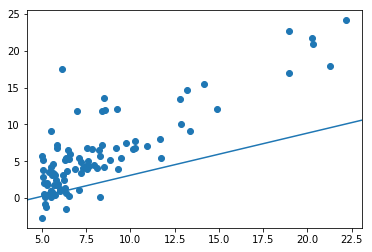

In [87]:
fig, ax = plt.subplots()
ax.scatter(Xex1data1,yex1data1)

# plot the line as a line connecting 2 pts., via the slope-intercept formula
x_min,x_max = ax.get_xlim()
y_min, y_max = b_1d_out, b_1d_out + Theta_1d_out * ( x_max-x_min)
ax.plot([x_min,x_max], [y_min,y_max])
ax.set_xlim([x_min,x_max])

In [110]:
feature_columns = [tf.feature_column.numeric_column(key="X")]

In [111]:
LinRegest = tf.estimator.LinearRegressor( feature_columns=feature_columns )

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1b274c9950>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpaHnmRn', '_save_summary_steps': 100}


In [115]:
# write a function to decode a line from the text file 
def decode_func_txt(line):
    record_defaults =[[0.0],[0.0]]
    line = tf.decode_csv(line, record_defaults=record_defaults, field_delim=',')
    return line[:-1], line[-1] # X_i, y_i, only the last value in a line 
                            # is the output value, the prior values are input values  

def create_1dimXydataset_fn(path,m_i,num_repeats=None,bool_shuffle=True,
                            shuffle_buffer_size=10000):
    """
    @fn create_1dimXydataset_fun
    @param path, string, a string with the filename's path
    @param m_i, a positive integer, number of examples in a batch
    @param num_repeats, a positive integer or None, number of times to repeat, 
                        None is for indefinitely
    @param bool_shuffle = True 
    @param shuffle_buffer_size, a positive integer, default is 10000
    """
    def input_fn():
        dataset = (
            tf.data.TextLineDataset(path) # create a dataset from a file 
                .map(decode_func_txt, num_parallel_calls=m_i)
                .batch(m_i)                
        )
        
        if num_repeats is None:
            dataset=dataset.repeat() # repeat indefinitely
        else:
            dataset=dataset.repeat(num_repeats)

        if bool_shuffle:
            dataset=dataset.shuffle(shuffle_buffer_size)    
            
        # create iterator
        iterator = dataset.make_one_shot_iterator()  
        
        # separate the input X data from the output y data
        X_next, y_next = iterator.get_next()

        # we'll need to return the iterator as well to initialize it at tf.Session time
        return dict(zip( ["X","y"], [X_next, y_next]) )
#        return iterator.get_next()
    return input_fn

In [116]:
ex1data1_fn = create_1dimXydataset_fn(sample_datasets_fileloc_str + "/ex1data1.txt", 
                                      128, None,False)

In [117]:
LinRegest.train( input_fn = ex1data1_fn, steps=1000 )

ValueError: None values not supported.

In [88]:
import imports85

ImportError: No module named imports85